In [162]:
%config InlineBackend.figure_format='retina'

"""
Modified from source: https://github.com/tensorflow/addons/issues/358
"""
from PIL import Image
import numpy as np
import pylab as plt
import pandas as pd
import tensorflow as tf


@tf.function
def otsu(images):
    """
    otsu's method of thresholding
    
    Take grayscale images and return boolean masks
    """
    
    ###### guassian blurring first ######
    sigma = 10
    dtype=tf.float32
    batch_size, h, w, n_channels = images.shape
    kernel_size = sigma*4
    x = tf.range(-kernel_size // 2 + 1, kernel_size // 2 + 1, dtype=dtype)
    g = tf.math.exp(-(tf.pow(x, 2) / (2 * tf.pow(tf.cast(sigma, dtype), 2))))
    g_norm2d = tf.pow(tf.reduce_sum(g), 2)
    g_kernel = tf.tensordot(g, g, axes=0) / g_norm2d
    g_kernel = tf.expand_dims(g_kernel, axis=-1)
    g_kernel = tf.expand_dims(tf.tile(g_kernel, (1, 1, n_channels)), axis=-1)
    g_kernel = tf.cast(g_kernel, tf.dtypes.float32)
    img = tf.image.convert_image_dtype(images, tf.dtypes.float32)
    # valid padding as we dont really care about edges anyway
    images = tf.nn.conv2d(img, g_kernel, [1, 1, 1, 1], padding="VALID")[:, :, :, 0]
    ###### guassian blurring ends ######

    images = tf.cast(images, tf.int32)
    batch_size, h, w = images.shape
    hist = tf.map_fn(lambda x: tf.math.bincount(x, dtype=tf.int32, minlength=256, maxlength=256), images)
    
    current_max = tf.zeros(batch_size, dtype=tf.float32)
    threshold = tf.zeros(batch_size, dtype=tf.int32)
    
    total = h * w

    spre = tf.TensorArray(dtype=tf.int32, size=256, clear_after_read=False)
    sw = tf.TensorArray(dtype=tf.int32, size=256, clear_after_read=False)
    spre = spre.write(0, hist[:, 0])
    sw = sw.write(0, tf.zeros(batch_size, dtype=tf.int32))

    for i in tf.range(1, 256):
        spre = spre.write(i, spre.read(i-1) + hist[:, i])
        sw = sw.write(i, sw.read(i-1) + (i * hist[:, i]))

    spre = spre.stack()
    sw = sw.stack()
    spre = tf.transpose(spre)
    sw = tf.transpose(sw)
    
    temp_meanB = tf.where(tf.equal(spre[:, 0], 0), 
                          tf.constant(0., dtype=tf.float32), 
                          tf.cast(sw[:, i]/spre[:, 0], dtype=tf.float32))
    temp_meanF = tf.cast((sw[:, 255] - sw[:, 0])/(total - spre[:, 0]), dtype=tf.float32)
    not_broke = tf.not_equal(total - spre[:, i], -9999)
    
    for i in tf.range(256):
        not_broke = tf.logical_or(not_broke, tf.not_equal(total, spre[:, i]))
        
        meanB = tf.where(tf.equal(spre[:, i], 0), 
                         tf.constant(0., dtype=tf.float32), 
                         tf.cast(sw[:, i]/spre[:, i], dtype=tf.float32))
        meanF = tf.cast((sw[:, 255] - sw[:, i])/(total - spre[:, i]), dtype=tf.float32)
        
        meanB = tf.where(not_broke, meanB, temp_meanB)
        meanF = tf.where(not_broke, meanF, temp_meanF)
        
        varBetween = tf.cast(total - spre[:, i], dtype=tf.float32) * tf.cast(spre[:, i], dtype=tf.float32) * ((meanB-meanF)**2)
        threshold = tf.where(tf.logical_and(tf.greater(varBetween, current_max), not_broke), 
                             i, 
                             threshold)
        current_max = tf.where(tf.logical_and(tf.greater(varBetween, current_max), not_broke), 
                               varBetween, 
                               current_max)
        
        temp_meanB = meanB
        temp_meanF = meanF

    final = tf.greater(images, tf.stack([tf.ones((h, w), dtype=tf.int32)*threshold[i] for i in range(batch_size)]))

    return final

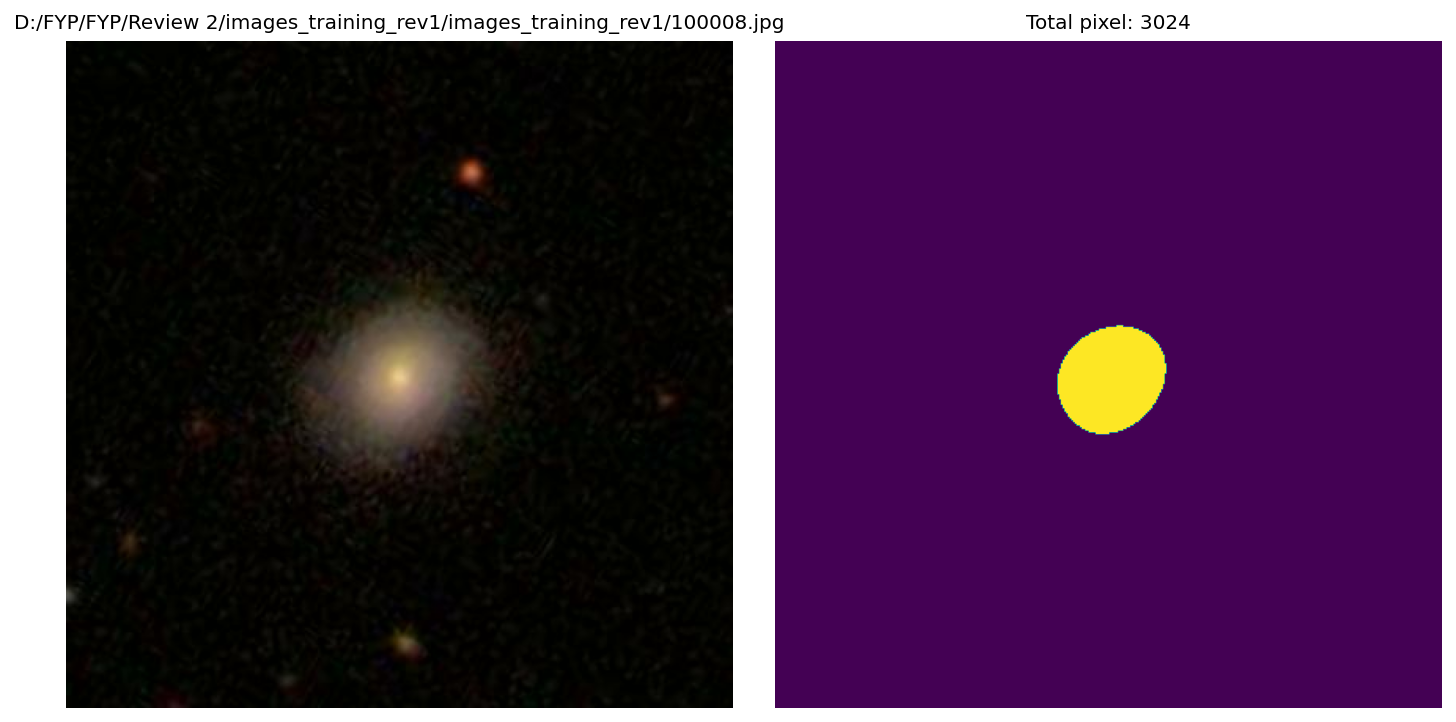

In [4]:
path = "D:/FYP/FYP/Review 2/images_training_rev1/images_training_rev1/100008.jpg"

img = tf.image.decode_jpeg(tf.io.read_file(path))

T = otsu(tf.expand_dims(img, axis=0))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].set_title(path, fontsize=10)
ax[0].imshow(img)
ax[0].axis("off")

ax[1].set_title(f"Total pixel: {np.sum(T)}", fontsize=10)
ax[1].imshow(T[0])
ax[1].axis("off")
fig.tight_layout()

In [13]:
from tqdm import tqdm
import numpy as np
import tensorflow as tf


class TFImgGenerator:
    """
    Using Tensorflow to quickly loop throught all galaxy images with all CPU/GPU resources
    """
    def __init__(self, folder,batch=64):
        self.folder = folder
        self.file_list = tf.io.match_filenames_once(f"./{folder}/*.jpg")
        self.num_file = self.file_list.shape[0]
        self.idx = 0
        self.batch = batch
        
        self.dataset = tf.data.Dataset.from_tensor_slices((self.file_list))
        self.dataset = self.dataset.map(self.read_img_otsu, num_parallel_calls=tf.data.AUTOTUNE).batch(self.batch).prefetch(tf.data.AUTOTUNE)
        
    def read_img_otsu(self, filename):
        image_string = tf.io.read_file(filename)
        image_decoded = tf.io.decode_image(image_string)
        return image_decoded

In [39]:
ds_ab = TFImgGenerator(folder="images_test_rev1/images_test_rev1", batch=128)

result_c = np.zeros(ds_ab.num_file)
current_idx = 0

for i in tqdm(ds_ab.dataset):
    T = otsu(i)
    tempresult = tf.math.count_nonzero(T, axis=(1, 2))
    current_shape = tempresult.shape[0]
    result_c[current_idx:current_idx+current_shape] = tempresult
    current_idx+=current_shape
np.savetxt("Output/Intermediate/gsize_result.csv", result_c)

100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [17:42<00:00,  1.70s/it]


In [61]:
def read_all_img(filepaths,gsize):
    all_img = []
    for i in range(len(filepaths)):
        if gsize[i]>cropping_threshold:
            img = Image.fromarray(plt.imread(filepaths[i])).resize(size=(new_h, new_w))
        else:
            img = plt.imread(filepaths[i])[cropping_x:cropping_y, cropping_x:cropping_y, :]
        all_img.append(img)
    return np.stack(all_img)

In [56]:
gsize_sdss = np.genfromtxt("Output/Intermediate/gsize_result.csv")

cropping_threshold = 17500
cropping_x = 128
cropping_y = 384
new_h = 256
new_w = 256
native_pixel_resolution = 0.262

In [57]:
import glob
filepaths = np.array(glob.glob("images_test_rev1/images_test_rev1/*.jpg"))
gsize = np.array(np.genfromtxt("Output/Intermediate/gsize_result.csv"))
dataset = read_all_img(filepaths[:10],gsize[:10])

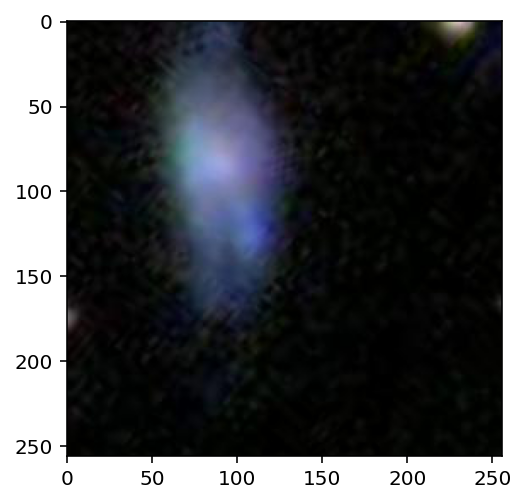

In [75]:
plt.imshow(dataset[9])

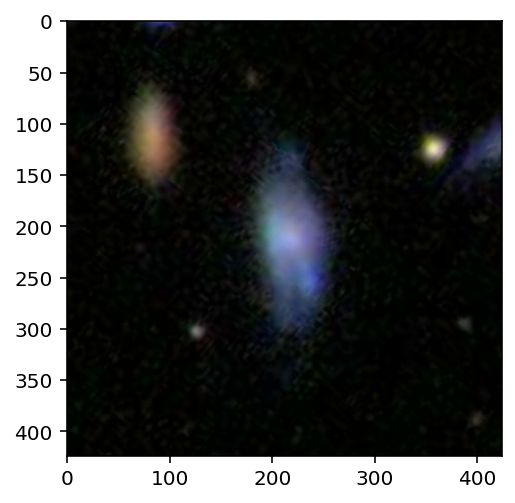

In [76]:
img = tf.image.decode_jpeg(tf.io.read_file(filepaths[9]))
plt.imshow(img)

# Testing

In [83]:
from skimage.transform import resize

In [209]:
ds_ab = TFImgGenerator(folder="Custom_input", batch=128)

result_c = np.zeros(ds_ab.num_file)
current_idx = 0

for i in tqdm(ds_ab.dataset):
    T = otsu(i)
    tempresult = tf.math.count_nonzero(T, axis=(1, 2))
    current_shape = tempresult.shape[0]
    result_c[current_idx:current_idx+current_shape] = tempresult
    current_idx+=current_shape
np.savetxt("Output/Intermediate/gsize_custom_result.csv", result_c)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.67s/it]


In [210]:
filepaths = np.array(glob.glob("Custom_input/*.jpg"))
gsize = np.genfromtxt("Output/Intermediate/gsize_custom_result.csv")
dataset = read_all_img(filepaths,gsize)

In [211]:
ORIG_SHAPE = (424,424)
CROP_SIZE = (256,256)
IMG_SHAPE = (64,64)

def resize_image(x):
    x = resize(x, IMG_SHAPE)
    return x

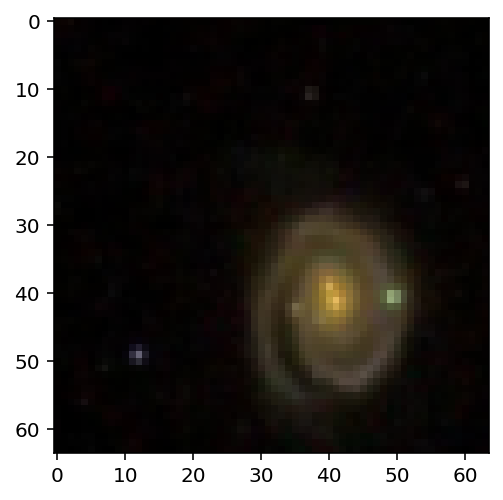

In [212]:
resized_data = []
for i in range(len(filepaths[:10])):
    resized_data.append(resize_image(dataset[i]))
    
plt.imshow(resize_image(dataset[0]))

In [213]:
resized_again = np.array(resized_data[0])

In [214]:
from keras.models import model_from_json
# load json and create model
json_file = open('Output/Model/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
                        # load weights into new model
loaded_model.load_weights("Output/Model/model.h5")
print("Loaded model from disk")

Loaded model from disk


In [215]:
import os
from tqdm import tqdm
batch_size = 128

val_files = os.listdir('Custom_input/')
val_predictions = []
N_val = len(val_files)
X = np.array(resized_data)
y_pred = loaded_model.predict(X)
val_predictions.append(y_pred)
val_predictions = np.array(val_predictions)
Y_pred = np.vstack(val_predictions)

In [216]:
Y_pred.shape

(2, 37)

In [217]:
import pandas as pd
df111 = pd.read_csv('sample_submission_testing.csv')
df111 = df111.drop('GalaxyID',axis=1)

In [218]:
df = pd.DataFrame(Y_pred,columns=df111.columns)
df

,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,0.06665,0.922097,0.012182,0.020076,0.896255,0.241032,0.654164,0.775795,0.126432,0.03494,...,0.003686,0.318719,0.334306,0.127229,0.087636,0.360934,0.117036,0.040471,0.033444,0.178443
1,0.06665,0.922097,0.012182,0.020076,0.896255,0.241032,0.654164,0.775795,0.126432,0.03494,...,0.003686,0.318719,0.334306,0.127229,0.087636,0.360934,0.117036,0.040471,0.033444,0.178443


In [219]:
def return_result(path_obtained):
    print("The obtained classes are : ",path_obtained)
    print()
    if 'Class1.1' in path_obtained:
        print("It is a smooth Galaxy")
    if 'Class1.2' in path_obtained:
        print("It has features and disk")
    if 'Class1.3' in path_obtained:
        print("It is a star/artifact")

    if 'Class2.1' in path_obtained:
        print("It is a disk viewed edge on")
    if 'Class2.2' in path_obtained:
        print("It is not a disk viewed edge on")

    if 'Class3.1' in path_obtained:
        print("There is a bar feature at the center of galaxy")
    if 'Class3.2' in path_obtained:
        print("There is NO bar feature at the center of galaxy")

    if 'Class4.1' in path_obtained:
        print("There is a sign of spiral arm pattern")
    if 'Class4.2' in path_obtained:
        print("There is NO sign of spiral arm pattern")

    if 'Class5.1' in path_obtained:
        print("There is no Buldge in the center")
    if 'Class5.2' in path_obtained:
        print("There is a just noticible Buldge in the center")
    if 'Class5.3' in path_obtained:
        print("There is a obvious Buldge in the center")
    if 'Class5.4' in path_obtained:
        print("There is dominant Buldge in the center")

    if 'Class6.1' in path_obtained:
        print("There is something odd")
    if 'Class6.2' in path_obtained:
        print("There is nothing odd")


    if 'Class7.1' in path_obtained:
        print("It is completely round")
    if 'Class7.2' in path_obtained:
        print("It is inbetween round")
    if 'Class7.3' in path_obtained:
        print("It is cigar shaped")

    if 'Class8.1' in path_obtained:
        print("There is a ring")
    if 'Class8.2' in path_obtained:
        print("There is a lens or arc")
    if 'Class8.3' in path_obtained:
        print("It is distributed")
    if 'Class8.4' in path_obtained:
        print("It is irregular")
    if 'Class8.5' in path_obtained:
        print("Cant Find")
    if 'Class8.6' in path_obtained:
        print("It is a Merger Galaxy")
    if 'Class8.7' in path_obtained:
        print("There is a Dust Lane")

    if 'Class9.1' in path_obtained:
        print("It is rounded at the center")
    if 'Class9.2' in path_obtained:
        print("It is BOXY at the center")
    if 'Class9.3' in path_obtained:
        print("It has no buldge at the center")

    if 'Class10.1' in path_obtained:
        print("It has tight spiral arms")
    if 'Class10.2' in path_obtained:
        print("It has medium tight spiral arms")
    if 'Class10.3' in path_obtained:
        print("It has loose spiral arms")

    if 'Class11.1' in path_obtained:
        print("There is 1 spiral arm")
    if 'Class11.2' in path_obtained:
        print("There is 2 spiral arm")
    if 'Class11.3' in path_obtained:
        print("There is 3 spiral arm")
    if 'Class11.4' in path_obtained:
        print("There is 4 spiral arm")
    if 'Class11.5' in path_obtained:
        print("There is more than 4 spiral arm")
    if 'Class11.6' in path_obtained:
        print("Can't tell the number of spiral arm")

    print("The END")

In [220]:
df

,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,0.06665,0.922097,0.012182,0.020076,0.896255,0.241032,0.654164,0.775795,0.126432,0.03494,...,0.003686,0.318719,0.334306,0.127229,0.087636,0.360934,0.117036,0.040471,0.033444,0.178443
1,0.06665,0.922097,0.012182,0.020076,0.896255,0.241032,0.654164,0.775795,0.126432,0.03494,...,0.003686,0.318719,0.334306,0.127229,0.087636,0.360934,0.117036,0.040471,0.033444,0.178443


C:\Users\swade\anaconda3\lib\site-packages\pygraphviz\agraph.py:1402: RuntimeWarning: Warning: pos attribute for edge (root,Class1.1) doesn't have 3n+1 points

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


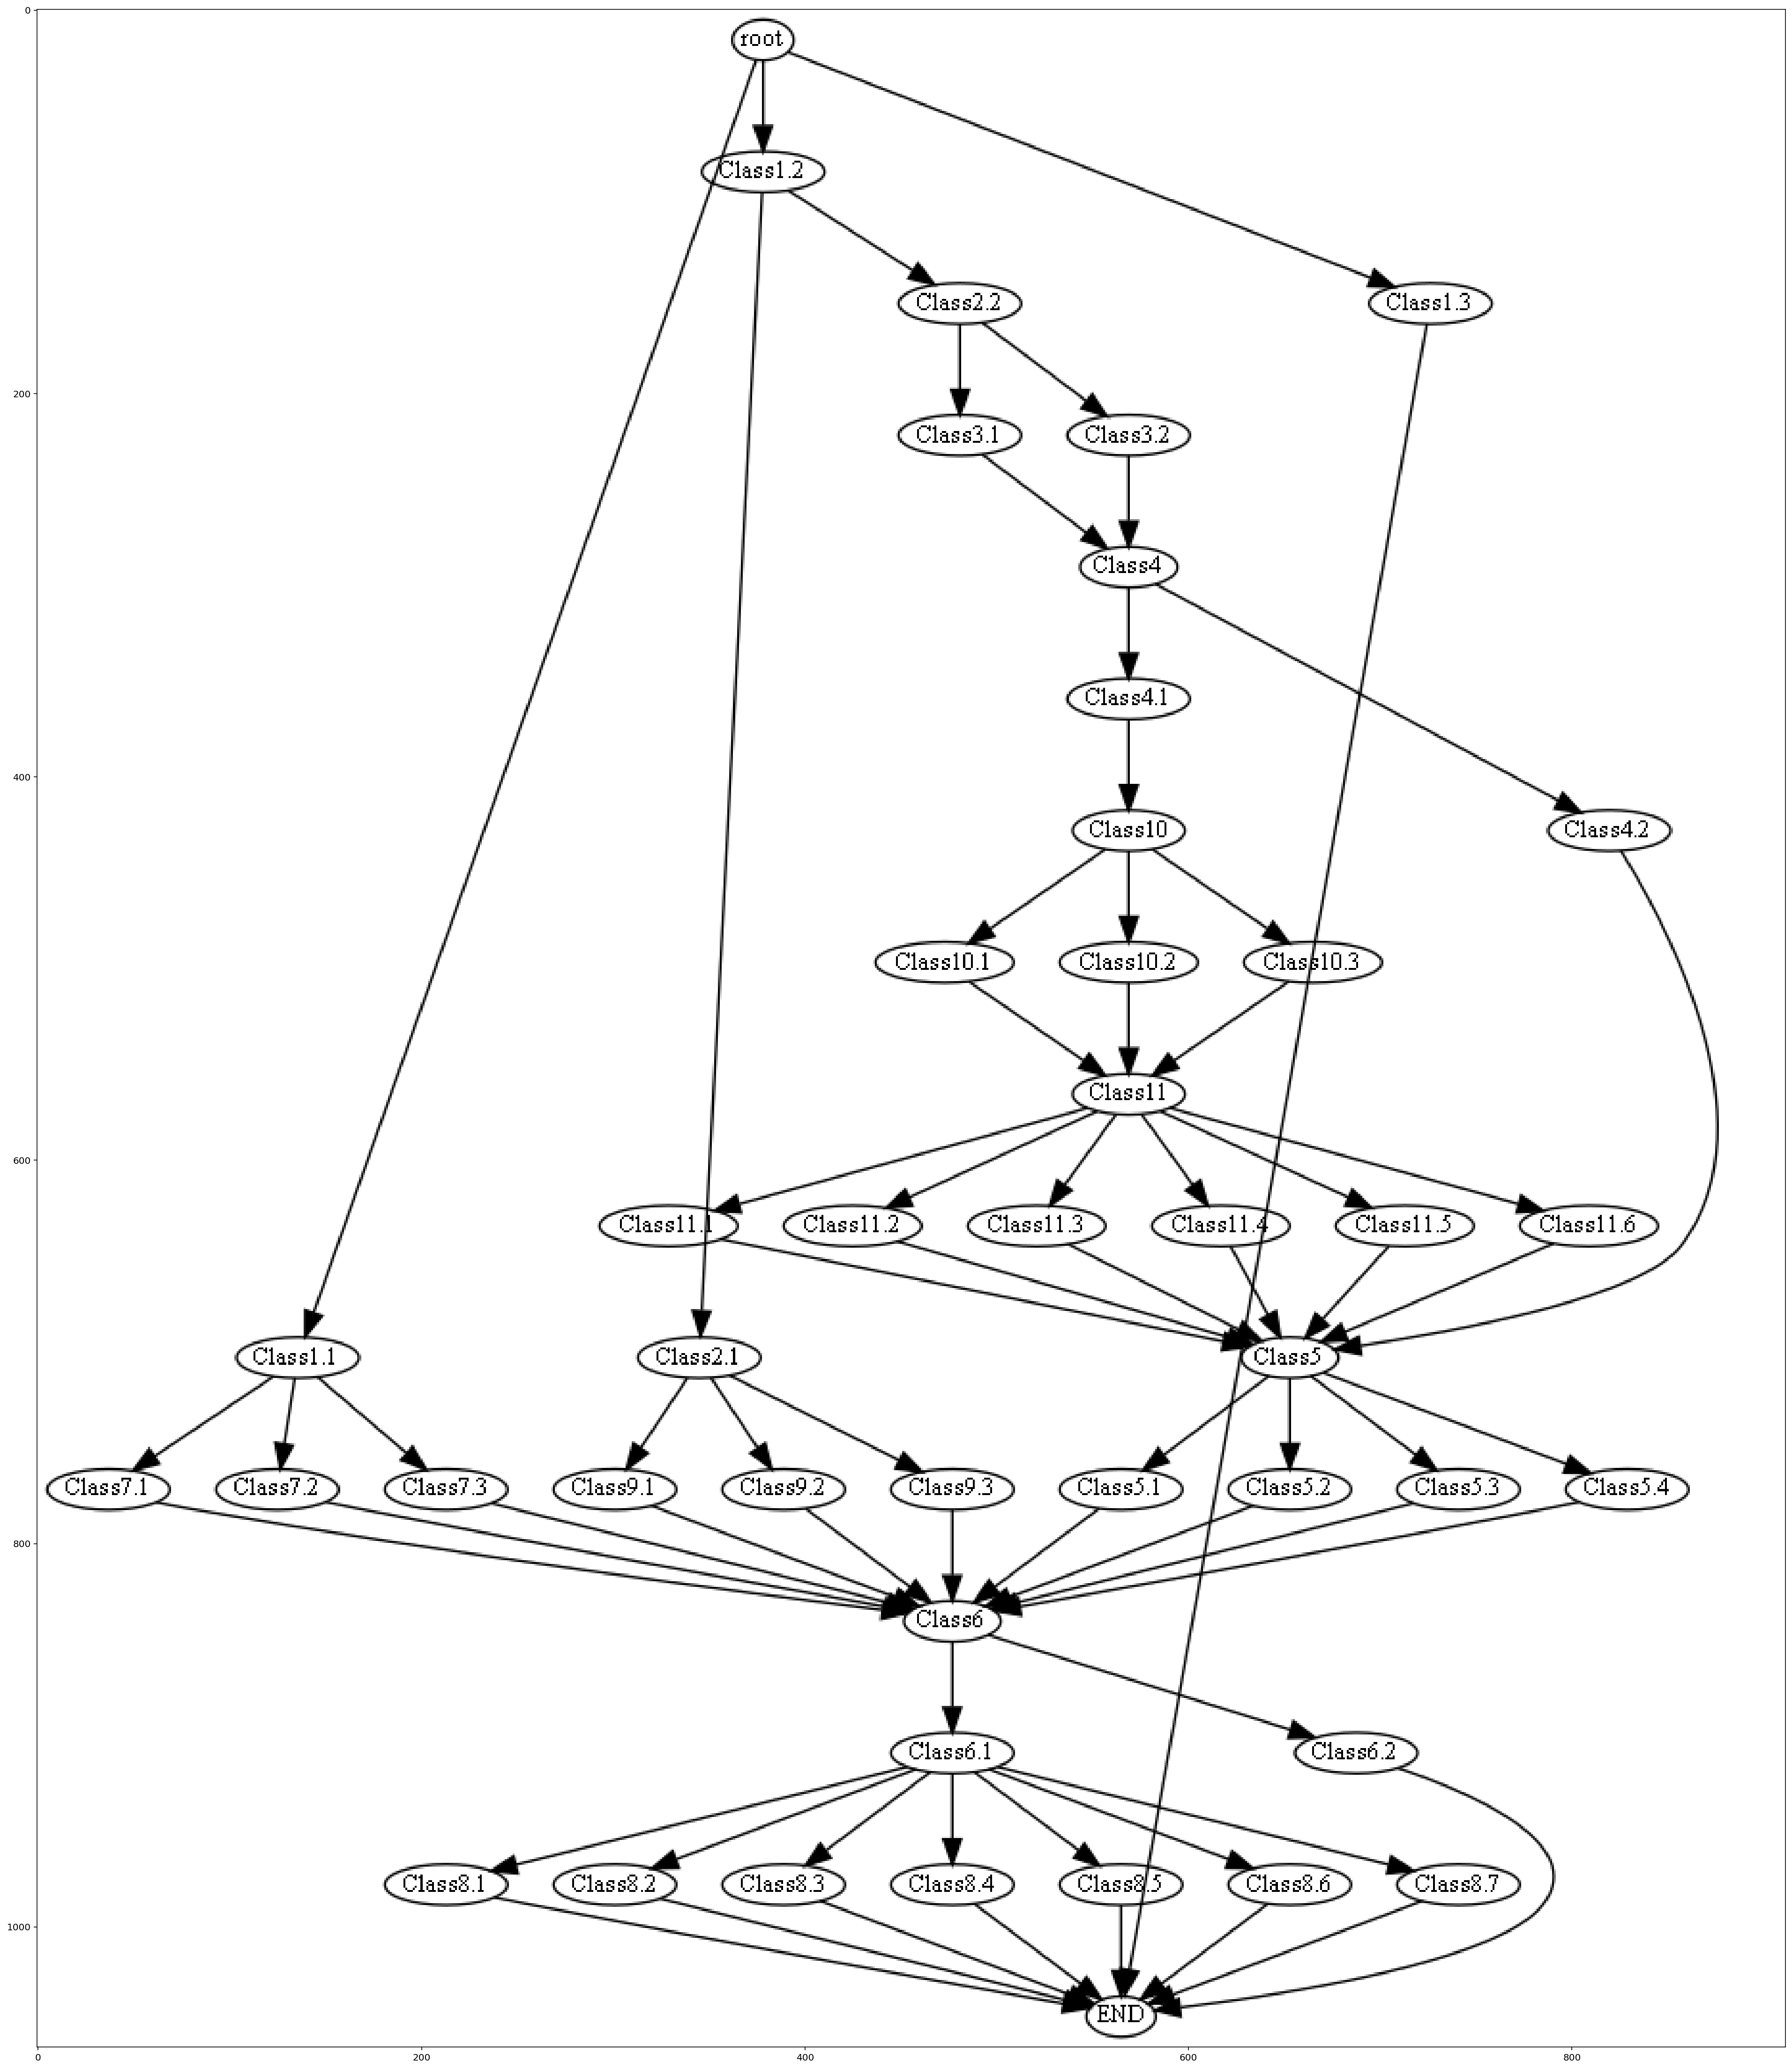

In [221]:
from matplotlib import pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
import networkx as nx
from PIL import Image
g1 = nx.DiGraph()
g1.add_edges_from([("root", "Class1.1"), ("root", "Class1.2"), ("root", "Class1.3"), ("Class1.1", "Class7.1"),("Class1.1", "Class7.2"),("Class1.1", "Class7.3"),("Class1.2", "Class2.1"),("Class1.2", "Class2.2"),
                  ("Class2.1", "Class9.1"),("Class2.1", "Class9.2"),("Class2.1", "Class9.3"),("Class2.2", "Class3.1"),("Class2.2", "Class3.2"),("Class7.1", "Class6"),("Class7.2", "Class6"),("Class7.3", "Class6"),
                  ("Class6","Class6.1"),("Class6","Class6.2"),("Class6.1","Class8.1"),("Class6.1","Class8.2"),("Class6.1","Class8.3"),("Class6.1","Class8.4"),("Class6.1","Class8.5"),("Class6.1","Class8.6"),("Class6.1","Class8.7"),
                   ("Class6.2","END"),("Class8.1","END"),("Class8.2","END"),("Class8.3","END"),("Class8.4","END"),("Class8.5","END"),("Class8.6","END"),("Class8.7","END"),("Class1.3","END"),
                  ("Class9.1", "Class6"),("Class9.2", "Class6"),("Class9.3", "Class6"),("Class3.1", "Class4"),("Class4","Class4.1"),("Class4","Class4.2"),("Class3.1", "Class4"),("Class3.2", "Class4"),("Class4.1", "Class10"),("Class4.2", "Class5"),
                  ("Class10","Class10.1"),("Class10","Class10.2"),("Class10","Class10.3"),("Class10.1","Class11"),("Class10.2","Class11"),("Class10.3","Class11"),
                  ("Class11","Class11.1"),("Class11","Class11.2"),("Class11","Class11.3"),("Class11","Class11.4"),("Class11","Class11.5"),("Class11","Class11.6"),
                  ("Class11.1","Class5"),("Class11.2","Class5"),("Class11.3","Class5"),("Class11.4","Class5"),("Class11.5","Class5"),("Class11.6","Class5"),
                  ("Class5","Class5.1"),("Class5","Class5.2"),("Class5","Class5.3"),("Class5","Class5.4"),("Class5.1","Class6"),("Class5.2","Class6"),("Class5.3","Class6"),("Class5.4","Class6")])

# nx.nx_agraph.write_dot(g1,'test.dot')
# pos=graphviz_layout(g1, prog='dot')
# nx.draw(g1, pos, with_labels=False, arrows=False)
# plt.show()

A = nx.nx_agraph.to_agraph(g1)
A.layout('dot', args='-Nfontsize=10 -Nwidth=".2" -Nheight=".2" -Nmargin=0 -Gfontsize=8')
A.draw('test.png')
img = Image.open('test.png')
plt.figure(figsize=(40,40))
plt.imshow(img)

In [222]:
edges = list(nx.edge_bfs(g1,"root"))
df1 = pd.DataFrame(edges)
df1.to_csv('tree.csv')

In [223]:
def search(className):
    cl = []
    for i,classes in enumerate(df1.iloc[:,0]):
        if(classes == className):
            cl.append(df1.iloc[i][1])
    return cl

In [224]:
search('Class7.2')

['Class6']

In [225]:
def find_max(row,classArr):
    max = -9999
    class_ans = ''
    for classes in classArr:
        if classes == 'Class6':
            return find_max(row,['Class6.1','Class6.2'])
        if classes == 'Class4':
            return find_max(row,['Class4.1','Class4.2'])
        if classes == 'Class10':
            return find_max(row,['Class10.1','Class10.2','Class10.3'])
        if classes == 'Class5':
            return find_max(row,['Class5.1','Class5.2','Class5.3','Class5.4'])
        if classes == 'Class11':
            return find_max(row,['Class11.1','Class11.2','Class11.3','Class11.4','Class11.5','Class11.6'])
        
        if df[classes][row] > max :
            max = df[classes][row]
            class_ans = classes
    return class_ans

In [226]:
search('Class6.2')[0]

'END'

In [227]:
df1.iloc[:,1]

0     Class1.1
1     Class1.2
2     Class1.3
3     Class7.1
4     Class7.2
        ...   
64      Class5
65      Class5
66      Class5
67      Class5
68      Class5
Name: 1, Length: 69, dtype: object

In [228]:
 def get_result(index):
    values_per_cat = np.array(df.iloc[index,0:3])
    maxarg = np.argmax(values_per_cat)
    begin = df.columns[maxarg]
    curr_class = begin
    path_obtained = []
    path_obtained.append(begin)
    while(True):
        print("Searchin child of",curr_class)
        arr = search(curr_class)
        if(arr[0] == 'END'):
            print("The end")
            break

        max_class = find_max(index,arr)
        print("Max of ",curr_class,"is",max_class)
        curr_class = max_class
        path_obtained.append(curr_class)
        
    return path_obtained

In [229]:
path_obtained = get_result(0)

Searchin child of Class1.2
Max of  Class1.2 is Class2.2
Searchin child of Class2.2
Max of  Class2.2 is Class3.2
Searchin child of Class3.2
Max of  Class3.2 is Class4.1
Searchin child of Class4.1
Max of  Class4.1 is Class10.2
Searchin child of Class10.2
Max of  Class10.2 is Class11.2
Searchin child of Class11.2
Max of  Class11.2 is Class5.3
Searchin child of Class5.3
Max of  Class5.3 is Class6.2
Searchin child of Class6.2
The end


In [230]:
path_obtained

['Class1.2',
 'Class2.2',
 'Class3.2',
 'Class4.1',
 'Class10.2',
 'Class11.2',
 'Class5.3',
 'Class6.2']

In [231]:
return_result(path_obtained)

The obtained classes are :  ['Class1.2', 'Class2.2', 'Class3.2', 'Class4.1', 'Class10.2', 'Class11.2', 'Class5.3', 'Class6.2']

It has features and disk
It is not a disk viewed edge on
There is NO bar feature at the center of galaxy
There is a sign of spiral arm pattern
There is a obvious Buldge in the center
There is nothing odd
It has medium tight spiral arms
There is 2 spiral arm
The END
